In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import collections
import copy

import amfe
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator, apply_cyclic_symmetry, get_all_dofs, rotate_u, set_cyclic_modes_to_component
from amfe.cyclic.cyclic import create_voigt_rotation_matrix, assemble_cyclic_modes, cyclic_symmetry_modal_analysis, Cyclic_Symmetry_Modal_Analysis
from amfe.cyclic.cyclic import create_rotated_component, create_voigt_rotation_matrix
from amfe.utils.utils import get_dofs
from amfe.linalg.arnoldi import arnoldi_iteration, inverse_arnoldi_iteration, general_inverse_arnoldi_iteration, generalized_arnoldi_iteration
from amfe.linalg.arnoldi import lanczos, is_eigvec, nullspace, LinearSys, power_iteration, ProjLinearSys, compute_modes, eigvec_error_vector, is_nullspace
from amfe.units import convert
msh_file = r'meshes\one_forth_disk_quad.msh'


m = amfe.Mesh()
m.import_msh(msh_file)


Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.



<IPython.core.display.Javascript object>


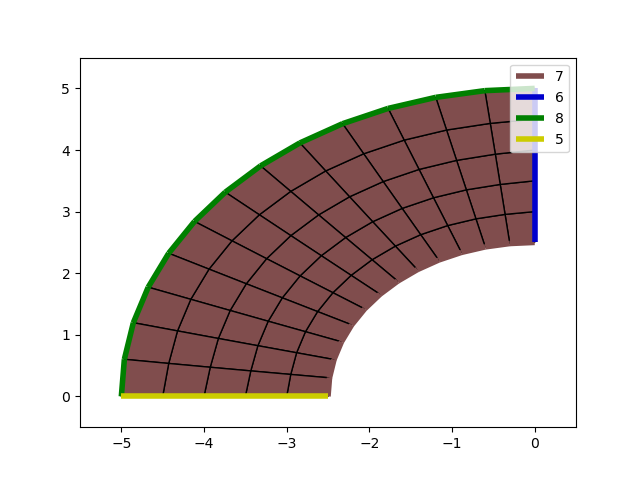

In [2]:
amfe.plot2Dmesh(m)

In [3]:
dirsub = m.get_submesh('phys_group', 7)

cyclic_left = m.get_submesh('phys_group', 5)
cyclic_right = m.get_submesh('phys_group', 6)
domain = m.set_domain('phys_group',9)
domain.split_in_partitions('phys_group')

from ipywidgets import interact
n = len(cyclic_right.global_node_list)-1
@interact(node_id_left=(0,n,1),node_id_right=(0,n,1)) 
def plot_nodes(node_id_left=0,node_id_right=0):
    fig, ax1 = plt.subplots(figsize=(5,5))
    amfe.plot_domain(domain,ax=ax1)
    amfe.plot_submesh(dirsub,ax=ax1,plot_1d=True)
    amfe.plot_submesh(cyclic_left,ax=ax1,plot_1d=True)
    ax1.plot(cyclic_left.get_node_coord(cyclic_left.global_node_list[node_id_left])[0],cyclic_left.get_node_coord(cyclic_left.global_node_list[node_id_left])[1],'o')
    ax1.plot(cyclic_right.get_node_coord(cyclic_right.global_node_list[node_id_right])[0],cyclic_right.get_node_coord(cyclic_right.global_node_list[node_id_right])[1],'o')

interactive(children=(IntSlider(value=0, description='node_id_left', max=5), IntSlider(value=0, description='n…

In [4]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
my_comp.set_domain(9,my_material)



Preallocating the stiffness matrix
Done preallocating stiffness matrix with 65 elements and 168 dofs.
Time taken for preallocation: 0.00 seconds.


In [5]:
theta = theta = np.pi/2.0 #
n_modes = 10
cyclic_obj = Cyclic_Symmetry_Modal_Analysis(my_comp,
                               dirsub,
                               cyclic_left,
                               cyclic_right,
                               sector_angle=theta,
                               unit='rad',
                               tol_radius = 1e-3, 
                               node_diam_range = (0,10),
                               n_modes=n_modes)

comp_list = cyclic_obj.comp_ND_list
s = cyclic_obj.selector_operator


xy direction choosen for cyclic symmetry


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


<IPython.core.display.Javascript object>


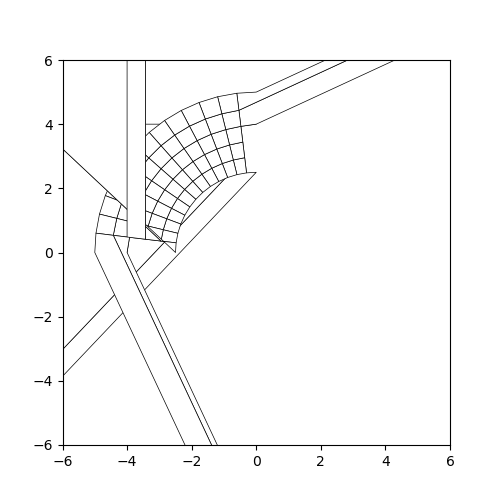

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=1, desc…

In [48]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import mpl_toolkits.mplot3d as a3
from ipywidgets import interact

my_comp_list = []
n_sector = int((2.0*np.pi)/theta)
    
my_comp.u_output = []
node_diam = 0
my_comp_i = comp_list[node_diam]



fig4,ax3 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot1(factor=1.0,mode_id=1):
    ax3.clear()
    amfe.plot_system_solution(my_comp_i, factor=1000*factor, ax = ax3, u_id = mode_id)
    ax3.set_xlim(bc)
    ax3.set_ylim(bc)


#ax3.set_axis_off()

#factor_list = 0.2*np.sin(np.linspace(0,2*np.pi,20))
#ani = FuncAnimation(fig4,  plot1,factor_list , init_func=init,interval=10, blit=True)


<IPython.core.display.Javascript object>


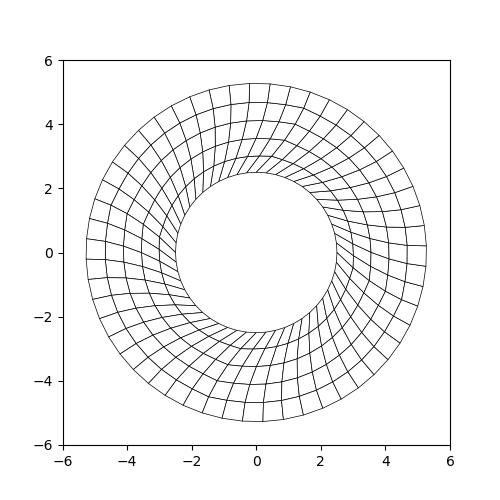

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=0, desc…

In [7]:
comp_list = []
for i in range(n_sector):
    my_comp_i = create_rotated_component(my_comp_i,s,sector_id=i, node_id=node_diam, theta=theta, unit='rad', dimension=2)
    comp_list.append(my_comp_i)

fig5,ax5 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot2(factor=1.0,mode_id=0):
    ax5.clear()
    for my_comp_i in comp_list:
        amfe.plot_system_solution(my_comp_i, factor=1000*factor, ax = ax5, u_id = mode_id)
    ax5.set_xlim(bc)
    ax5.set_ylim(bc)


In [8]:
# get dofs
id_matrix = my_comp.assembly_class.id_matrix
all_dofs = get_all_dofs(id_matrix)
dir_dofs = amfe.get_dofs(dirsub, direction ='xy', id_matrix=id_matrix)

# defining sector angle
theta = np.pi/2.0 #

# creating node pairs
contact = amfe.Cyclic_Contact(cyclic_left,cyclic_right,sector_angle=theta,unit='rad',tol_radius=000.1)

# modifying order of nodes to have the correct node pairs for cyclic symmetry
cyclic_left.global_node_list = contact.slaves_nodes
cyclic_right.global_node_list = contact.master_nodes


superset = OrderedSet(dir_dofs)
left_dofs = OrderedSet(amfe.get_dofs(cyclic_left, direction ='xy', id_matrix=id_matrix)) - superset
right_dofs = OrderedSet(amfe.get_dofs(cyclic_right, direction ='xy', id_matrix=id_matrix)) - superset


boundary_dofs = superset | left_dofs | right_dofs
interior_dofs = list(OrderedSet(all_dofs) - boundary_dofs)
left_dofs = list(left_dofs)
right_dofs = list(right_dofs)


dof_dict = collections.OrderedDict()
dof_dict['d'] = dir_dofs 
dof_dict['r'] = right_dofs
dof_dict['l'] = left_dofs 
dof_dict['i'] = interior_dofs

s = SelectionOperator(dof_dict,id_matrix)

K, f = my_comp.assembly_class.assemble_k_and_f()
M = my_comp.assembly_class.assemble_m()


M_block = s.create_block_matrix(M)
M_sector = s.assemble_matrix(M,['r','l','i'])

K_block = s.create_block_matrix(K)
K_sector = s.assemble_matrix(K,['r','l','i'])


WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [9]:
dof_dict2 = collections.OrderedDict()
dof_dict2['r'] = list(range(s.length['r']))
dof_dict2['l'] = list(range(dof_dict2['r'][-1]+1,dof_dict2['r'][-1] + s.length['l']+1))
dof_dict2['i'] = list(range(dof_dict2['l'][-1]+1,dof_dict2['l'][-1] + s.length['i']+1))


# createing selection operator
s2 = SelectionOperator(dof_dict2,id_matrix)

# building cyclic matrices
#theta = -theta
beta = node_diam*theta
ej_beta_plus = np.exp(1J*beta)

#building Boolean matrices
Bl = s2.build_B('l')
Br = s2.build_B('r')
nc, ndof = Br.shape
nr = ndof - nc 
T = create_voigt_rotation_matrix(nc, theta, dim=2)

# Building the cyclic constraint
#C_n = T.dot(Bl) - ej_beta_plus*Br
#C_n = -T.dot(Br) + ej_beta_plus*Bl
C_n =  - ej_beta_plus*Br  + T.dot(Bl) 

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [10]:
CCT = C_n.dot(C_n.conj().T)
CCT_inv = 0.5*sparse.eye(nc) #sparse.linalg.inv(CCT)
computed_CCT_inv = sparse.linalg.inv(CCT.tocsc() )

invertion_error = abs(CCT_inv - computed_CCT_inv).toarray().max()
print('Analytical inverse error = %f' %invertion_error)
P_n = sparse.eye(ndof) - C_n.conj().T.dot(CCT_inv.dot(C_n))


Analytical inverse error = 0.000000


In [11]:
proj_la_obj = ProjLinearSys(K_sector,M_sector,P_n)
proj_la = proj_la_obj.getLinearOperator()

b_0 = np.random.rand(ndof)
b = P_n.dot(b_0)
b = b/np.linalg.norm(b)
Q, H = generalized_arnoldi_iteration(proj_la,b,3*n_modes)
val, vec = np.linalg.eig(H)

dual_V = Q.dot(vec)

In [12]:
mode_id = 1
norm_vec = np.linalg.norm(dual_V[:,mode_id])
print('Norm of eigenvector %f' %norm_vec)
e = eigvec_error_vector(K_sector,dual_V[:,mode_id],1/val[mode_id],M_sector)

e = 10000000*dual_V[:,mode_id]
C_ne = C_n.dot(e)
alpha = sparse.linalg.spsolve(CCT,C_ne)

eigcorr = C_n.T.dot(alpha)

Norm of eigenvector 1.000000


In [13]:
alpha

array([-5.02354624e+06-1.42379705e-09j,  4.73934682e+06-1.23146539e-08j,
       -1.90193376e-09-1.22142723e-23j, -8.34479436e-11+4.61954007e-24j,
        5.43205480e+04-1.80595638e-11j, -1.16669660e+05+2.39458008e-10j,
        9.82930858e-11-1.10549265e-26j,  1.51195647e+06+1.54940216e-09j,
        2.06389911e-11+1.37993296e-25j, -6.90020548e-09+8.69981862e-24j])

In [14]:
dual_V[:,mode_id] = dual_V[:,mode_id] - eigcorr
u_dual = assemble_cyclic_modes(s,dual_V,node_id=node_diam,compute_left=False,dimension=2)

new_comp = copy.deepcopy(my_comp)
new_comp.u_output = []
new_comp.u_output = list(u_dual.T)

<IPython.core.display.Javascript object>


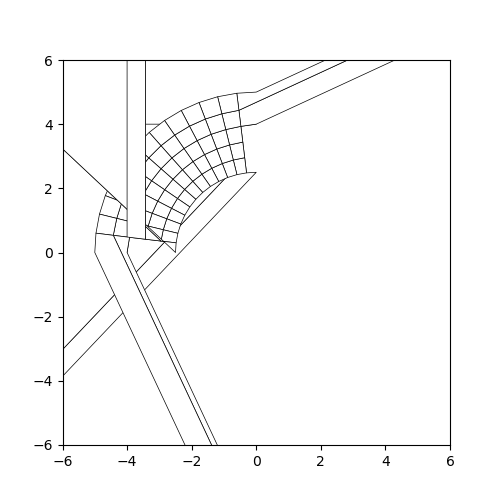

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=1, desc…

In [15]:

fig4,ax3 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot1(factor=1.0,mode_id=1):
    ax3.clear()
    amfe.plot_system_solution(new_comp, factor=10*factor, ax = ax3, u_id = mode_id)
    ax3.set_xlim(bc)
    ax3.set_ylim(bc)

<IPython.core.display.Javascript object>


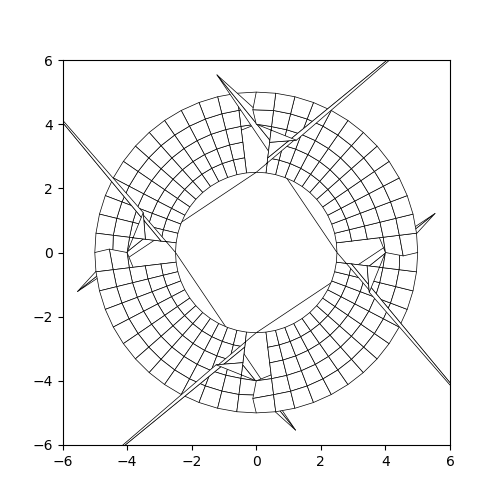

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=0, desc…

In [16]:
comp_list = []
for i in range(n_sector):
    my_comp_i = create_rotated_component(new_comp,s,sector_id=i, node_id=node_diam, theta=theta, unit='rad', dimension=2)
    comp_list.append(my_comp_i)

fig5,ax5 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot2(factor=1.0,mode_id=0):
    ax5.clear()
    for my_comp_i in comp_list:
        amfe.plot_system_solution(my_comp_i, factor=10*factor, ax = ax5, u_id = mode_id)
    ax5.set_xlim(bc)
    ax5.set_ylim(bc)

In [17]:
Q

array([[-2.54275531e-02+0.j,  6.51574524e-02+0.j,  6.91643618e-01+0.j,
        ...,  6.58700846e-02+0.j, -3.69500701e-02+0.j,
         1.09483416e-02+0.j],
       [ 7.74895713e-02+0.j,  7.03944769e-01+0.j, -6.67506223e-02+0.j,
        ..., -2.01273955e-03+0.j, -6.09885840e-04+0.j,
         4.40458224e-05+0.j],
       [ 3.14259061e-02+0.j,  4.26103644e-17+0.j,  1.08082966e-15+0.j,
        ..., -9.23261715e-03+0.j, -2.24002378e-01+0.j,
         6.31085816e-02+0.j],
       ...,
       [ 9.31539176e-02+0.j, -7.74986658e-20+0.j, -2.62307636e-19+0.j,
        ..., -3.16541629e-02+0.j,  5.77440472e-02+0.j,
        -5.24988487e-03+0.j],
       [ 2.88778005e-02+0.j, -4.00648627e-19+0.j, -2.48620943e-18+0.j,
        ..., -3.71753020e-02+0.j, -3.41984831e-02+0.j,
         1.08722485e-01+0.j],
       [ 1.35899490e-01+0.j, -1.80768065e-19+0.j, -3.66394298e-20+0.j,
        ..., -4.66263521e-02+0.j, -1.43384845e-03+0.j,
         8.22026379e-02+0.j]])

In [18]:
mode_id = 2
ur = new_comp.u_output[mode_id ][s.selection_dict['r']]
print(ur)

[ 5.30881658e-01-1.11841082e-02j  4.09564014e-01-1.82336090e-01j
  1.42977095e-16-7.33530116e-17j -7.07077494e-17-7.57537224e-18j
 -8.34408400e-04+1.09504351e-03j  1.06018695e-03-1.76454764e-03j
  1.09046887e-17-2.60682396e-18j  1.24185241e-01-4.02783102e-02j
  1.13597226e-19+5.34895432e-20j -5.89259321e-16-9.49555714e-17j]


In [19]:
ul = new_comp.u_output[mode_id ][s.selection_dict['l']]
print(ul)

[-4.09564014e-01+1.82336090e-01j  5.30881658e-01-1.11841082e-02j
  7.05213037e-17+7.51453693e-18j  1.42581549e-16-7.27606060e-17j
 -1.06018695e-03+1.76454764e-03j -8.34408400e-04+1.09504351e-03j
 -1.24185241e-01+4.02783102e-02j  8.35632420e-19+8.99657903e-19j
  5.89106080e-16+9.47539628e-17j -2.34591442e-19+5.92176880e-19j]


In [20]:
T.dot(ur)

array([-4.09564014e-01+1.82336090e-01j,  5.30881658e-01-1.11841082e-02j,
        7.07077494e-17+7.57537224e-18j,  1.42977095e-16-7.33530116e-17j,
       -1.06018695e-03+1.76454764e-03j, -8.34408400e-04+1.09504351e-03j,
       -1.24185241e-01+4.02783102e-02j,  1.85088415e-17-5.07315914e-18j,
        5.89259321e-16+9.49555714e-17j,  1.13597226e-19+5.34895432e-20j])

In [21]:
T.dot(ur) - ul

array([ 2.22044605e-16-2.77555756e-17j,  0.00000000e+00-1.56125113e-17j,
        1.86445671e-19+6.08353183e-20j,  3.95546123e-19-5.92405667e-19j,
       -7.37257477e-18+3.68628739e-18j,  3.36102673e-18-2.81892565e-18j,
        5.55111512e-17-1.38777878e-17j,  1.76732091e-17-5.97281705e-18j,
        1.53241710e-19+2.01608649e-19j,  3.48188668e-19-5.38687336e-19j])

In [22]:
s.length

{'d': 28, 'r': 10, 'l': 10, 'i': 120}

In [23]:
s.length['d'] + s.length['r'] + s.length['l']

48

In [24]:
mode = dual_V[:,0]

In [25]:
mode.shape

(140,)

In [26]:
np.exp(-1J*0)

(1-0j)

In [27]:
val1, vec1 = sparse.linalg.eigs(proj_la,k=10,v0=b)

<IPython.core.display.Javascript object>


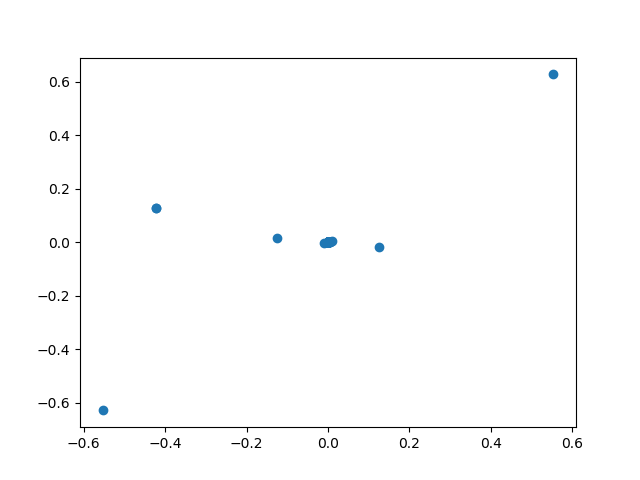

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [28]:
plt.figure()
plt.plot(dual_V[:,0],vec1[:,0],'o')
plt.show()

In [29]:
C_n.dot(C_n.conj().T).real.toarray()

array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]])

In [30]:
T.dot(T.T).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [31]:
T.toarray()

array([[ 6.123234e-17, -1.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  6.123234e-17,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  6.123234e-17, -1.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  6.123234e-17,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         6.123234e-17, -1.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         1.000000e+00,  6.123234e-17,  0.000000e+00,  0.0

In [32]:
proj_la.dtype

dtype('complex128')

In [33]:
np.complex(1)

(1+0j)

In [34]:
Kp = P_n.conj().T.dot(K_sector.dot(P_n))
Mp = P_n.conj().T.dot(M_sector.dot(P_n))
Dp = P_n.conj().toarray().T.dot(np.linalg.inv(K_sector.toarray()).dot(M_sector.toarray())).dot(P_n.toarray())

In [35]:
w, v = np.linalg.eigh(Dp)
new_id = np.argsort(w)[::-1]
w = w[new_id]
v = v[:,new_id]

In [36]:
is_eigvec(Dp,dual_V[:,0])

The L2 norm of the vectors ||(v2/||v2|| - v1/|| v1 ||)|| where A*v=scale*M*v , v1= scale * v2 is 1.441803


False

In [37]:
u_v = assemble_cyclic_modes(s,v,node_id=node_diam,compute_left=False,dimension=2)
new_comp = copy.deepcopy(my_comp)
new_comp.u_output = []
new_comp.u_output = list(u_v.T)

<IPython.core.display.Javascript object>


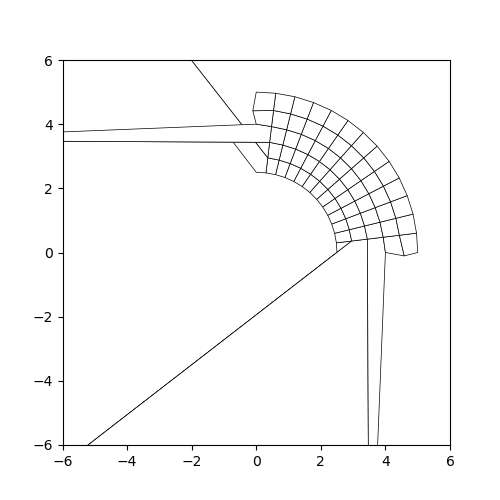

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=0, desc…

In [38]:

fig4,ax3 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot1(factor=1.0,mode_id=0):
    ax3.clear()
    amfe.plot_system_solution(new_comp, factor=10*factor, ax = ax3, u_id = mode_id)
    ax3.set_xlim(bc)
    ax3.set_ylim(bc)

<IPython.core.display.Javascript object>


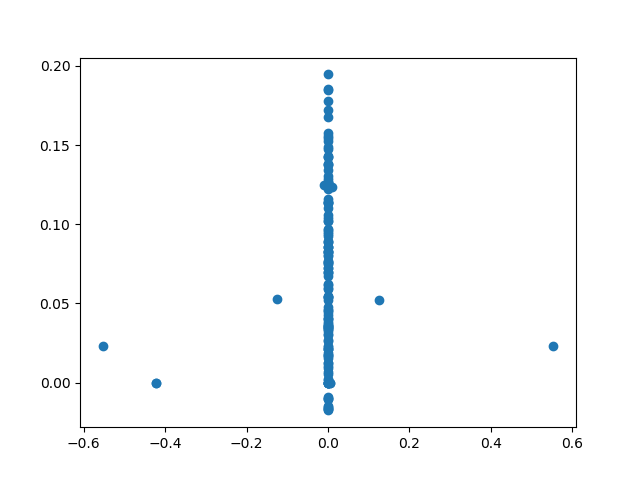

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [39]:
plt.figure()
plt.plot(dual_V[:,0],v[:,0],'o')
plt.show()

In [40]:
R_col1 = (ej_beta_plus.conj()*Br  + T.dot(Bl)).T
R_col2 = sparse.vstack([0*sparse.eye(2*nc,nr-nc).tocsc(), sparse.eye(ndof-2*nc).tocsc()]).tocsc()
R = sparse.hstack([R_col1,R_col2]).tocsc()
        
Krr = R.conj().T.dot(K_sector).dot(R)
Mrr = R.conj().T.dot(M_sector).dot(R)

print(is_nullspace(C_n,R))

True


In [41]:
C_n.dot(R[:,0]).toarray()

array([[0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])

In [42]:
# dual ciclic matrices
k = 0.0
zero_block = sparse.csr_matrix((nc,nc))
M_dual_row_1 = sparse.hstack((M_sector, k*C_n.conj().T))
M_dual_row_2 = sparse.hstack((k*C_n,zero_block))
M_dual = sparse.vstack((M_dual_row_1, M_dual_row_2)).tocsc()

K_dual_row_1 = sparse.hstack((K_sector, C_n.conj().T))
K_dual_row_2 = sparse.hstack((C_n,zero_block))
K_dual = sparse.vstack((K_dual_row_1, K_dual_row_2)).tocsc()


linear_system_obj = LinearSys(K_dual,M_dual)
Dual_S_operator = linear_system_obj.getLinearOperator() 

#eigval2, V2 = sparse.linalg.eigs(Dual_S_operator, k=16)
#V2 = V2[:-nc,0]
from scipy  import linalg as linalg
eigval2, V2 = linalg.eig(K_dual.todense(), M_dual.todense())

new_id = np.argsort(eigval2)
eigval2 = eigval2[new_id[:-nc]]
V2 = V2[:-nc,new_id[:-nc]]

<IPython.core.display.Javascript object>


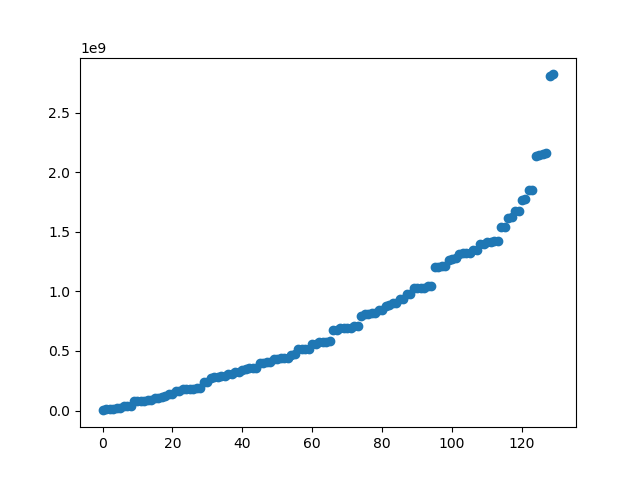

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [43]:
plt.figure()
plt.plot(eigval2,'o')

<IPython.core.display.Javascript object>


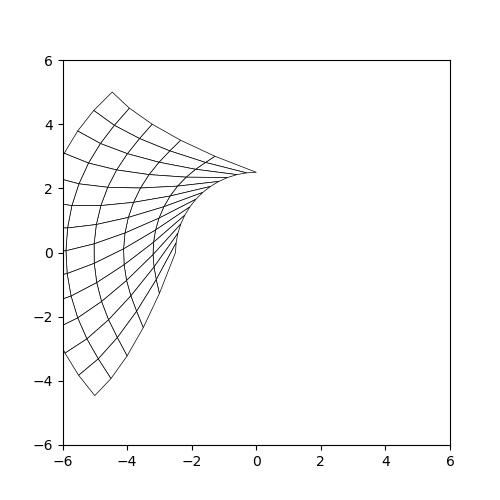

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=0, desc…

In [44]:
u_v = assemble_cyclic_modes(s,V2,node_id=node_diam,compute_left=False,dimension=2)
new_comp2 = copy.deepcopy(my_comp)
new_comp2.u_output = []
new_comp2.u_output = list(u_v.real.T)


fig5,ax5 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot1(factor=1.0,mode_id=0):
    ax5.clear()
    amfe.plot_system_solution(new_comp2, factor=1.0E11*factor, ax = ax5, u_id = mode_id)
    ax5.set_xlim(bc)
    ax5.set_ylim(bc)

In [45]:
is_nullspace(Kp,R)

False

In [46]:
Kp.dot(R[:,0]).toarray()

array([[ 1.86752173e+11+0.j],
       [-4.67703650e+08+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [-4.26692117e+10+0.j],
       [ 2.74490870e+08+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [-4.67703650e+08+0.j],
       [-1.86752173e+11+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 2.74490870e+08+0.j],
       [ 4.26692117e+10+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j],
       [ 0

<IPython.core.display.Javascript object>


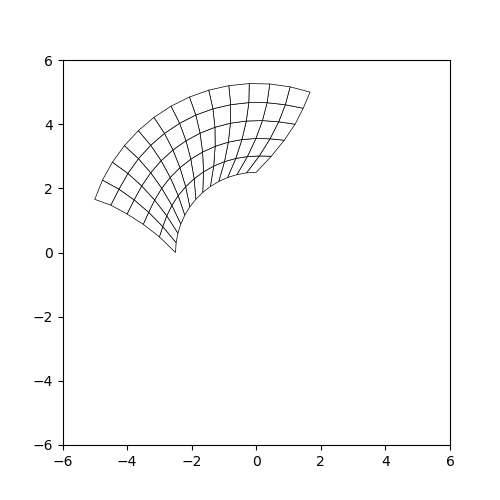

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=0, desc…

In [47]:
Dp_real = linalg.pinv(Kp.toarray()).dot(Mp.toarray())

w2, v2 = np.linalg.eig(Dp_real)
new_id = np.argsort(w2)[::-1]
w2 = w2[new_id]
v2 = v2[:,new_id]

u_v = assemble_cyclic_modes(s,v2,node_id=node_diam,compute_left=False,dimension=2)
new_comp2 = copy.deepcopy(my_comp)
new_comp2.u_output = []
new_comp2.u_output = list(u_v.real.T)


fig6,ax6 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot1(factor=1.0,mode_id=0):
    ax6.clear()
    amfe.plot_system_solution(new_comp2, factor=1.0E1*factor, ax = ax6, u_id = mode_id)
    ax6.set_xlim(bc)
    ax6.set_ylim(bc)